# Employee Sentiment Analysis

**Project Overview:**  
This project analyzes an unlabeled dataset of employee messages to evaluate sentiment and engagement. The analysis covers:

- **Sentiment Labeling:** Classifying each message as Positive, Negative, or Neutral using NLTK’s VADER (with numerical scores +1, -1, 0).
- **Exploratory Data Analysis (EDA):** Generating visualizations to understand data structure, sentiment distribution, monthly message frequency, and average sentiment.
- **Employee Score Calculation:** Computing monthly sentiment scores for each employee.
- **Employee Ranking:** Creating monthly ranking lists:
  - Top Three Positive Employees (highest positive scores).
  - Top Three Negative Employees (lowest scores).
- **Flight Risk Identification:** Flagging employees as potential flight risks if they send four or more negative messages in any rolling 30-day period.
- **Predictive Modeling:** Building a linear regression model (using scikit-learn) to forecast monthly sentiment trends, evaluated via mean squared error (MSE).

This notebook implements all tasks and generates the required visualizations and outputs.


In [1]:
# imports & initialization

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import nltk

# download necessary nltk data (vader lexicon)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\there\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# preprocessing & data loading
def preprocess_and_load_data(filepath):
    # reads csv file from filepath and conv. 'date' column into datetime obj.
    df = pd.read_csv(filepath)
    # print("columns in csv:", df.columns)  # temporary debugging
    df.rename(columns = {'from': 'employee_id'}, inplace = True)
    df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
    return df

In [3]:
# [TASK 1: Sentiment Labeling & Analysis] (using NLTK VADER)
def add_sentiment_labels(df):
    # adds sentiment labels to DataFrame using NLTK's VADER
    # labels -> based on compound score from VADER
    # >= 0.05 (POS.), <= 0.05 (NEG.), otherwise (NEUTR.)
    sid = SentimentIntensityAnalyzer()
    
    # helper funct. to deter. sentiment from text
    def get_sentiment(text):
        # use VADER to calc. polarity scores
        scores = sid.polarity_scores(text)
        # compound score rep overall sentiment
        compound = scores['compound']
        # text -> pos., neg., or netur.
        if compound >= 0.05:
            return 'POSITIVE'
        elif compound <= -0.05:
            return 'NEGATIVE'
        else:
            return 'NEUTRAL'
        
    # apply helper funct. on 'body' column
    df['sentiment'] = df['body'].astype(str).apply(get_sentiment)
    
    # map text sentiment labels to numerical scores
    score_map = {'POSITIVE': 1, 'NEGATIVE': -1, 'NEUTRAL': 0}
    df['score'] = df['sentiment'].map(score_map)
    
    # create addit. binary column (neg_flag) to indicate negative messages
    df['neg_flag'] = df['sentiment'].apply(lambda s: 1 if s == 'NEGATIVE' else 0)
    
    # return modified DataFrame with new columns
    return df

In [4]:
# [TASK 2: Exploratory Data Analysis (EDA)]
def run_eda(df):
    # generates & saves visualizations from dataset
    # (countplot for sentiment distrib. & chart saved in visual. folder)
    plt.figure(figsize = (8,5))
    sns.countplot(x = 'sentiment', data = df)
    plt.title("Sentiment Distribution")
    plt.savefig("visualization/sentiment_distribution.png")
    plt.show()

In [5]:
# [TASK 3: Employee Score Calculation (ESC)]
def calculate_employee_scores(df):
    # calculate monthly sentiment scores per employee
    # work on copy so original df not overriden
    df_copy = df.copy()
    df_copy.set_index('date', inplace = True)
    # group data by employee & month (using 'date' column) & sum 'score'
    monthly_scores = df_copy.groupby(['employee_id', pd.Grouper(freq = 'M')])['score'].sum().reset_index()
    # returns DataFrame of monthly scores
    return monthly_scores

In [6]:
# additional visualization: monthly message frequency
def plot_monthly_message_frequency(df):
    # gener. a line plot of monthly message freq.
    df_copy = df.copy()
    df_copy.set_index('date', inplace=True)
    monthly_frequency = df_copy.resample('ME').size()  # using 'ME' for month-end
    plt.figure(figsize=(10, 6))
    monthly_frequency.plot(marker='o')
    plt.title("Monthly Message Frequency")
    plt.xlabel("Month")
    plt.ylabel("Number of Messages")
    plt.tight_layout()
    plt.savefig("visualization/monthly_message_frequency.png")
    plt.close()

# additional visualization: monthly average sentiment score
def plot_monthly_average_sentiment(df):
    # gener. a bar chart of the average sentiment score per month
    df_copy = df.copy()
    df_copy.set_index('date', inplace=True)
    monthly_avg = df_copy.resample('ME')['score'].mean()
    plt.figure(figsize=(10, 6))
    monthly_avg.plot(kind = 'bar', color = 'skyblue')
    plt.title("Monthly Average Sentiment Score")
    plt.xlabel("Month")
    plt.ylabel("Average Score")
    plt.tight_layout()
    plt.savefig("visualization/monthly_average_sentiment.png")
    plt.close()

In [7]:
# [TASK 4: Employee Ranking]
def rank_employees(monthly_scores):
    # generates and prints lists of employees per month based on monthly sentiment scores
    rankings = {}
    # group by month ('date' column should have month-end timestamps)
    # for each month -> two lists:
    for month, group in monthly_scores.groupby('date'):
        # sort for pos. rank: score descending then employee id ascending
        top_positive = group.sort_values(by = ['score', 'employee_id'], ascending = [False, True]).head(3)
        # sort for pos. rank: score acsending then employee id ascending
        top_negative = group.sort_values(by = ['score', 'employee_id'], ascending = [True, True]).head(3)
        rankings[month] = {
            'positive': top_positive,
            'negative': top_negative
        }
        print(f"\nMonth: {month.date()}")
        print("Top Three Positive Employees:")
        print(top_positive[['employee_id', 'score']])
        print("Top Three Negative Employees:")
        print(top_negative[['employee_id', 'score']])
    # return dict mapping: month -> ranking
    return rankings

In [8]:
# [TASK 5: Flight Risk Identification]
def identify_flight_risks(df):
    # identifies employees who have sent 4 or more neg. messages (in 30 day per.)
    # work on copy of dataFrame
    df_copy = df.copy()
    if df_copy.index.name != 'date':
        df_copy.set_index('date', inplace = True)
    # sort by employee id and date
    df_copy = df_copy.sort_values(['employee_id', 'date'])
    
    # helper funct to group by employee and calc. 30 day roll. sum on neg. messages
    def rolling_negatives(group):
        # rolling window of 30 days (using index which is datetime)
        return group['neg_flag'].rolling('30D').sum()
    
    df_copy['neg_rolling_sum'] = df_copy.groupby('employee_id', group_keys = False).apply(rolling_negatives)
    # flag employees with rolling sum >= 4 as flight risks
    flight_risk_employees = df_copy[df_copy['neg_rolling_sum'] >= 4]['employee_id'].unique().tolist()
    print("\nFlight Risk Employees: ")
    print(flight_risk_employees)
    return flight_risk_employees

In [9]:
# [TASK 6: Predictive Modeling]
def run_predictive_model(monthly_scores):
    # using linear regression model to predict monthly sentiment scores
    # model utilizes month num. extracted from date as feature
    monthly_scores['month_num'] = monthly_scores['date'].dt.month
    x = monthly_scores[['month_num']]
    y = monthly_scores['score']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    # train lin. regr. model & using 'fit' mthod to find best lin. rel. bet. features
    model = LinearRegression().fit(x_train, y_train)
    # using trained model t omake predictions on test dataset
    predictions = model.predict(x_test)
    # calc. mse to determine model's accuracy (lower mse -> better predictive performance)
    mse = mean_squared_error(y_test, predictions)
    # prints mean squared error of model on a test split
    print("\nPredictive Modeling:")
    print("Mean Squared Error:", mse)

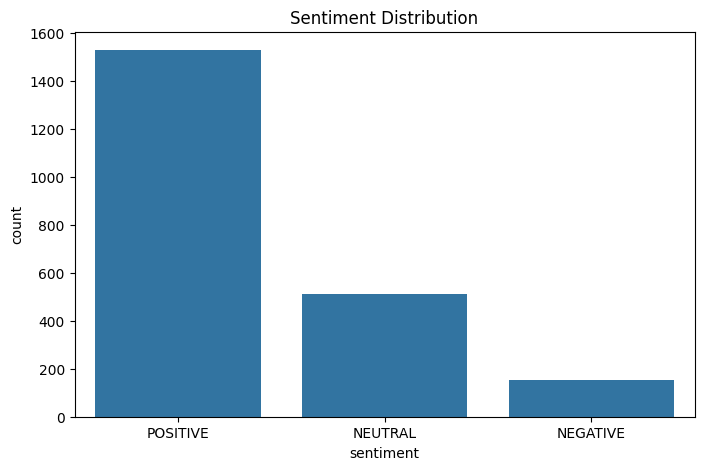

C:\Users\there\AppData\Local\Temp\ipykernel_26700\150260617.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_scores = df_copy.groupby(['employee_id', pd.Grouper(freq = 'M')])['score'].sum().reset_index()



Month: 2010-01-31
Top Three Positive Employees:
                 employee_id  score
120  kayne.coulter@enron.com     13
48       eric.bass@enron.com      9
144  lydia.delgado@enron.com      9
Top Three Negative Employees:
                     employee_id  score
0    bobette.riner@ipgdirect.com      1
96       johnny.palmer@enron.com      1
192      rhonda.denton@enron.com      1

Month: 2010-02-28
Top Three Positive Employees:
                    employee_id  score
73        john.arnold@enron.com     11
97      johnny.palmer@enron.com     10
1   bobette.riner@ipgdirect.com      7
Top Three Negative Employees:
                  employee_id  score
121   kayne.coulter@enron.com      1
145   lydia.delgado@enron.com      1
169  patti.thompson@enron.com      1

Month: 2010-03-31
Top Three Positive Employees:
                     employee_id  score
218         sally.beck@enron.com     11
74         john.arnold@enron.com      7
2    bobette.riner@ipgdirect.com      6
Top Three Negative Employ

C:\Users\there\AppData\Local\Temp\ipykernel_26700\2192202085.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_copy['neg_rolling_sum'] = df_copy.groupby('employee_id', group_keys = False).apply(rolling_negatives)


In [10]:
# main 
def main():
    # load data from csv (test.csv)
    df = preprocess_and_load_data("data/test.csv")
    
    # sentiment labeling & analysis (task 1)
    df = add_sentiment_labels(df)
    
    # run exp. data analysis (task 2)
    run_eda(df)
    plot_monthly_message_frequency(df)
    plot_monthly_average_sentiment(df)
    
    # calc. empl. monthly sent. scores (task 3)
    monthly_scores = calculate_employee_scores(df)
    
    # gener. empl. rankings based on monthly scores (task 4)
    rankings = rank_employees(monthly_scores)
    
    # identify flight risk employees (task 5)
    flight_risks = identify_flight_risks(df)
    
    # run predictive modeling (task 6)
    run_predictive_model(monthly_scores)

# main working smoothly now!
if __name__ == "__main__":
    main()